In [2]:
import json
import pprint
from collections import Counter
from operator import itemgetter
import csv
from dotmap import DotMap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
# pulizzia delle stringhe

def clean_up_str(string):
    a = ''
    if string:
        a = string.replace('\xa0', '').replace('  ', ' ').strip()
    return a  



# calcolo dell'anno (medio)

def date(r_col):

    lista=[]
    for v in r_col['values']:
        if v.value.timePrimitive:
            lista.append(int(v.value.timePrimitive.label[:4]))
            
    if len(lista)>=1:
        return int(np.rint(np.mean(lista)))
    else:
        return np.nan




# sintesi time-spen (anno medio: begin, at some time, end)

def datatio(r_col_begin, r_col_someTime, r_col_end, element):

    begin, some_time, end = date(r_col_begin), date(r_col_someTime), date(r_col_end)
    element+= [begin, some_time, end]

    return(element)


-------------

# I. Processetti - Panoramica generale

**Obbiettivo**: Analizzare e visualizzare la distribuzione dei processetti nel tempo con la possibilità di individuare specifici archi cronologici di interesse e aggregati sulla base della ‘motivation type’ (MT)

In [4]:
file = 'geovistory_query_exports/nb_overwiev_processetti_20220510.json'

with open(file, encoding='utf-8') as json_file:
    data = json.load(json_file)

dmData = DotMap(data)
dm_r = dmData.rows


### Processetti list = psl

psl=[['volume', 'section', 'number_archival_units', 'pk_processetto', 'enquiry', 'motivation_type',
 'start_date','end_date', 'anno', 'id_union', 'number_union']]


for r in dm_r:
    element = []
    # volume
    element += ['-'.join([v.entity_label for v in r.col_0.entities]) if len(r.col_0.entities)>=1 else np.nan]   

    # sezione (unità archivistica)
    element += [clean_up_str(r.col_1.entities[0].entity_label)]

    # numero di section per enquiry 
    element += [len(r.col_1.entities)]

    # enquiry 
    element += [r.col_2.entity.pk_entity, clean_up_str(r.col_2.entity.entity_label)]
   
    # motivation type
    element += [clean_up_str('; '.join([v.entity_label for v in r.col_3.entities])) if len(r.col_3.entities)>=1 else np.nan]

    # arco e anno processetto
    valor = []
    if len(r.col_4['values']) == 0:
        element += [np.nan, np.nan, np.nan]
    else:
        for v in  r.col_4['values']:
            valor.append(int(v.value.timePrimitive.label[:4]))
        element += [r.col_4['values'][0]['value'].timePrimitive.label[:10], r.col_4[
            'values'][len(r.col_4['values'])-1]['value'].timePrimitive.label[:10], round(np.mean(valor))]

    # union
    if len(r.col_5.entities)==1:
        element += [r.col_5.entities[0].pk_entity, len(r.col_5.entities)]
    elif len(r.col_5.entities)>1:
        element += ['-'.join([str(v.pk_entity) for v in r.col_5.entities]) if len(r.col_5.entities)>=1 else np.nan, len(r.col_5.entities)]  
    else:
        element += [np.nan, 0]
        
    psl.append(element)
    

df_proc = pd.DataFrame(psl[1:], columns=psl[0])  
df_proc.head()

    

,volume,section,number_archival_units,pk_processetto,enquiry,motivation_type,start_date,end_date,anno,id_union,number_union
0,EM 04,Processetto di Giovanni di Michele (da Cessalto),1,1006519,Giovanni di Michele (da Cessalto),Stato libero di “foresto”,1597-05-23,1597-05-23,1597.0,NaN,0
1,EM 05,Processetto di Francesco di Vincenzo Moscato (...,1,1006729,"Francesco di Vincenzo Moscato (da Fabriano, te...",Stato libero di “foresto”,1598-12-27,1598-12-27,1598.0,NaN,0
2,EM 04,Processetto di Pietro di Gennaro Costinovi (da...,1,1006883,"Pietro di Gennaro Costinovi (da Bergamo, tesse...",Stato libero di “foresto”,1597-05-26,1597-05-26,1597.0,NaN,0
3,EM 05,Processetto di Orsola di Angelo Collotis (da V...,1,1007147,Orsola di Angelo Collotis (da Visinale),Stato libero di “foresto”,1598-12-29,1598-12-29,1598.0,NaN,0
4,EM 05,Processetto di Ortensia di Leonardo Verona (da...,1,1007355,Ortensia di Leonardo Verona (da Venzone),Stato libero di “foresto”,1598-12-29,1598-12-29,1598.0,NaN,0


In [5]:
# Integrazione del frame con colonne che permettano quantificazioni differenziate 


motivation_t =[]
lista_mt = []
aggregazione_mt = []
proc_type = []
for i, r in df_proc.iterrows():
    if isinstance(r.motivation_type, str):
        lista = r.motivation_type.split('; ')
        lista.sort()
        motivation = '; '.join(lista)
        lista_mt.append(lista)
        motivation_t.append(motivation)
        if ';' in r.motivation_type:
            aggregazione_mt.append('motivazioni plurime')
        else:
            aggregazione_mt.append(r.motivation_type)

        
        if 'atipico' in r.motivation_type:
            proc_typest = 'atipico'
        elif 'Vedovanza' in r.motivation_type:
            proc_typest = 'vedovanza'
        elif 'assente' in r.motivation_type:
            proc_typest = 'a lungo assente'
        elif 'libero' in r.motivation_type:
            proc_typest = 'stato libero'
        
        proc_type.append(proc_typest)
            

       
    else:
        lista_mt.append(np.nan)
        motivation_t.append(np.nan)
        aggregazione_mt.append(np.nan) 
        proc_type.append('manca')

df_proc['lista_mt'], df_proc['motivation_type'], df_proc['aggregazione_mt'], df_proc['mt_priorita'] = lista_mt, motivation_t, aggregazione_mt, proc_type
df_proc


,volume,section,number_archival_units,pk_processetto,enquiry,motivation_type,start_date,end_date,anno,id_union,number_union,lista_mt,aggregazione_mt,mt_priorita
0,EM 04,Processetto di Giovanni di Michele (da Cessalto),1,1006519,Giovanni di Michele (da Cessalto),Stato libero di “foresto”,1597-05-23,1597-05-23,1597.0,NaN,0,[Stato libero di “foresto”],Stato libero di “foresto”,stato libero
1,EM 05,Processetto di Francesco di Vincenzo Moscato (...,1,1006729,"Francesco di Vincenzo Moscato (da Fabriano, te...",Stato libero di “foresto”,1598-12-27,1598-12-27,1598.0,NaN,0,[Stato libero di “foresto”],Stato libero di “foresto”,stato libero
2,EM 04,Processetto di Pietro di Gennaro Costinovi (da...,1,1006883,"Pietro di Gennaro Costinovi (da Bergamo, tesse...",Stato libero di “foresto”,1597-05-26,1597-05-26,1597.0,NaN,0,[Stato libero di “foresto”],Stato libero di “foresto”,stato libero
3,EM 05,Processetto di Orsola di Angelo Collotis (da V...,1,1007147,Orsola di Angelo Collotis (da Visinale),Stato libero di “foresto”,1598-12-29,1598-12-29,1598.0,NaN,0,[Stato libero di “foresto”],Stato libero di “foresto”,stato libero
4,EM 05,Processetto di Ortensia di Leonardo Verona (da...,1,1007355,Ortensia di Leonardo Verona (da Venzone),Stato libero di “foresto”,1598-12-29,1598-12-29,1598.0,NaN,0,[Stato libero di “foresto”],Stato libero di “foresto”,stato libero
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3413,EM 05,"Processetto di Gaspare Forzanini (da Bassano, ...",1,998606,"Gaspare Forzanini (da Bassano, calegher)",Stato libero di “foresto”,1598-12-18,1598-12-18,1598.0,NaN,0,[Stato libero di “foresto”],Stato libero di “foresto”,stato libero
3414,EM 04,Processetto di Cristina vedova di Nicola De Ga...,1,998615,Cristina vedova di Nicola De Gaspari (da Venezia),Vedovanza,1597-05-20,1597-05-20,1597.0,998630,1,[Vedovanza],Vedovanza,vedovanza
3415,EM 04,Processetto di Giovanni Maria di Antonio (da L...,1,998913,"Giovanni Maria di Antonio (da Lovere, tesser d...",Vedovanza,1597-05-21,1597-05-21,1597.0,998922,1,[Vedovanza],Vedovanza,vedovanza
3416,EM 05,Processetto di Andrea di Angelo Pasetto (da Ma...,1,999218,"Andrea di Angelo Pasetto (da Magno, erbariol)",Stato libero di “foresto”,1598-12-21,1598-12-21,1598.0,NaN,0,[Stato libero di “foresto”],Stato libero di “foresto”,stato libero


In [6]:
# un record per menzione

proc_list= [['volume', 'section', 'number_archival_units', 'pk_processetto',
       'enquiry', 'motivation_type', 'start_date', 'end_date', 'anno',
       'id_union', 'number_union', 'lista_mt', 'aggregazione_mt', 'mt_priorita', 'mt_singola', 'conto_mt']]
       
for i,r in df_proc.iterrows():
    if isinstance(r.lista_mt, list):
        for el in r.lista_mt:
            element = [v for v in r] + [el] + [len(r.lista_mt)]
            proc_list.append(element)
    else:
        element = [v for v in r] + [np.nan] + [0]
        proc_list.append(element)

dfn_proc = pd.DataFrame(proc_list[1:], columns=proc_list[0])


        

>   è possibile ridurre il dataset a: 'Pk_processetto', 'anno', 'mt_singola'

In [8]:
# Conteggio delle MT 
df_proc.groupby('motivation_type').agg({'pk_processetto':'count'}).sort_values(by='pk_processetto', ascending=False)

,pk_processetto
motivation_type,
Stato libero di “foresto”,2781
Vedovanza,464
Stato libero di persona lungamente assente da Venezia,53
Processetto atipico,38
Stato libero di persona lungamente assente da Venezia; Stato libero di “foresto”,26
Processetto atipico; Stato libero di “foresto”,19
Stato libero di “foresto”; Vedovanza,14
Processetto atipico; Vedovanza,11
Processetto atipico; Stato libero di persona lungamente assente da Venezia,4


In [9]:
# Conteggio di MT con priorità
df_proc.groupby('mt_priorita').agg({'pk_processetto':'count'}).sort_values(by='pk_processetto', ascending=False)

,pk_processetto
mt_priorita,
stato libero,2782
vedovanza,478
a lungo assente,79
atipico,74
manca,5


In [10]:
# Conteggio con aggregazione di MT multiple
df_proc.groupby('aggregazione_mt').agg({'pk_processetto':'count'}).sort_values(by='pk_processetto', ascending=False)

,pk_processetto
aggregazione_mt,
Stato libero di “foresto”,2781
Vedovanza,464
motivazioni plurime,76
Stato libero di persona lungamente assente da Venezia,53
Processetto atipico,38
Stato libero di veneziano,1


In [11]:
# Conteggio menzione MT  
dfn_proc.groupby('mt_singola').agg({'pk_processetto':'count'}).sort_values(by='pk_processetto', ascending=False)

,pk_processetto
mt_singola,
Stato libero di “foresto”,2821
Vedovanza,490
Stato libero di persona lungamente assente da Venezia,85
Processetto atipico,74
Stato libero di “foresto”,20
Stato libero di veneziano,1


In [12]:
time_line = pd.RangeIndex(1585, 1694).to_frame().rename(columns={0:'time_line'})

<AxesSubplot:xlabel='time_line'>

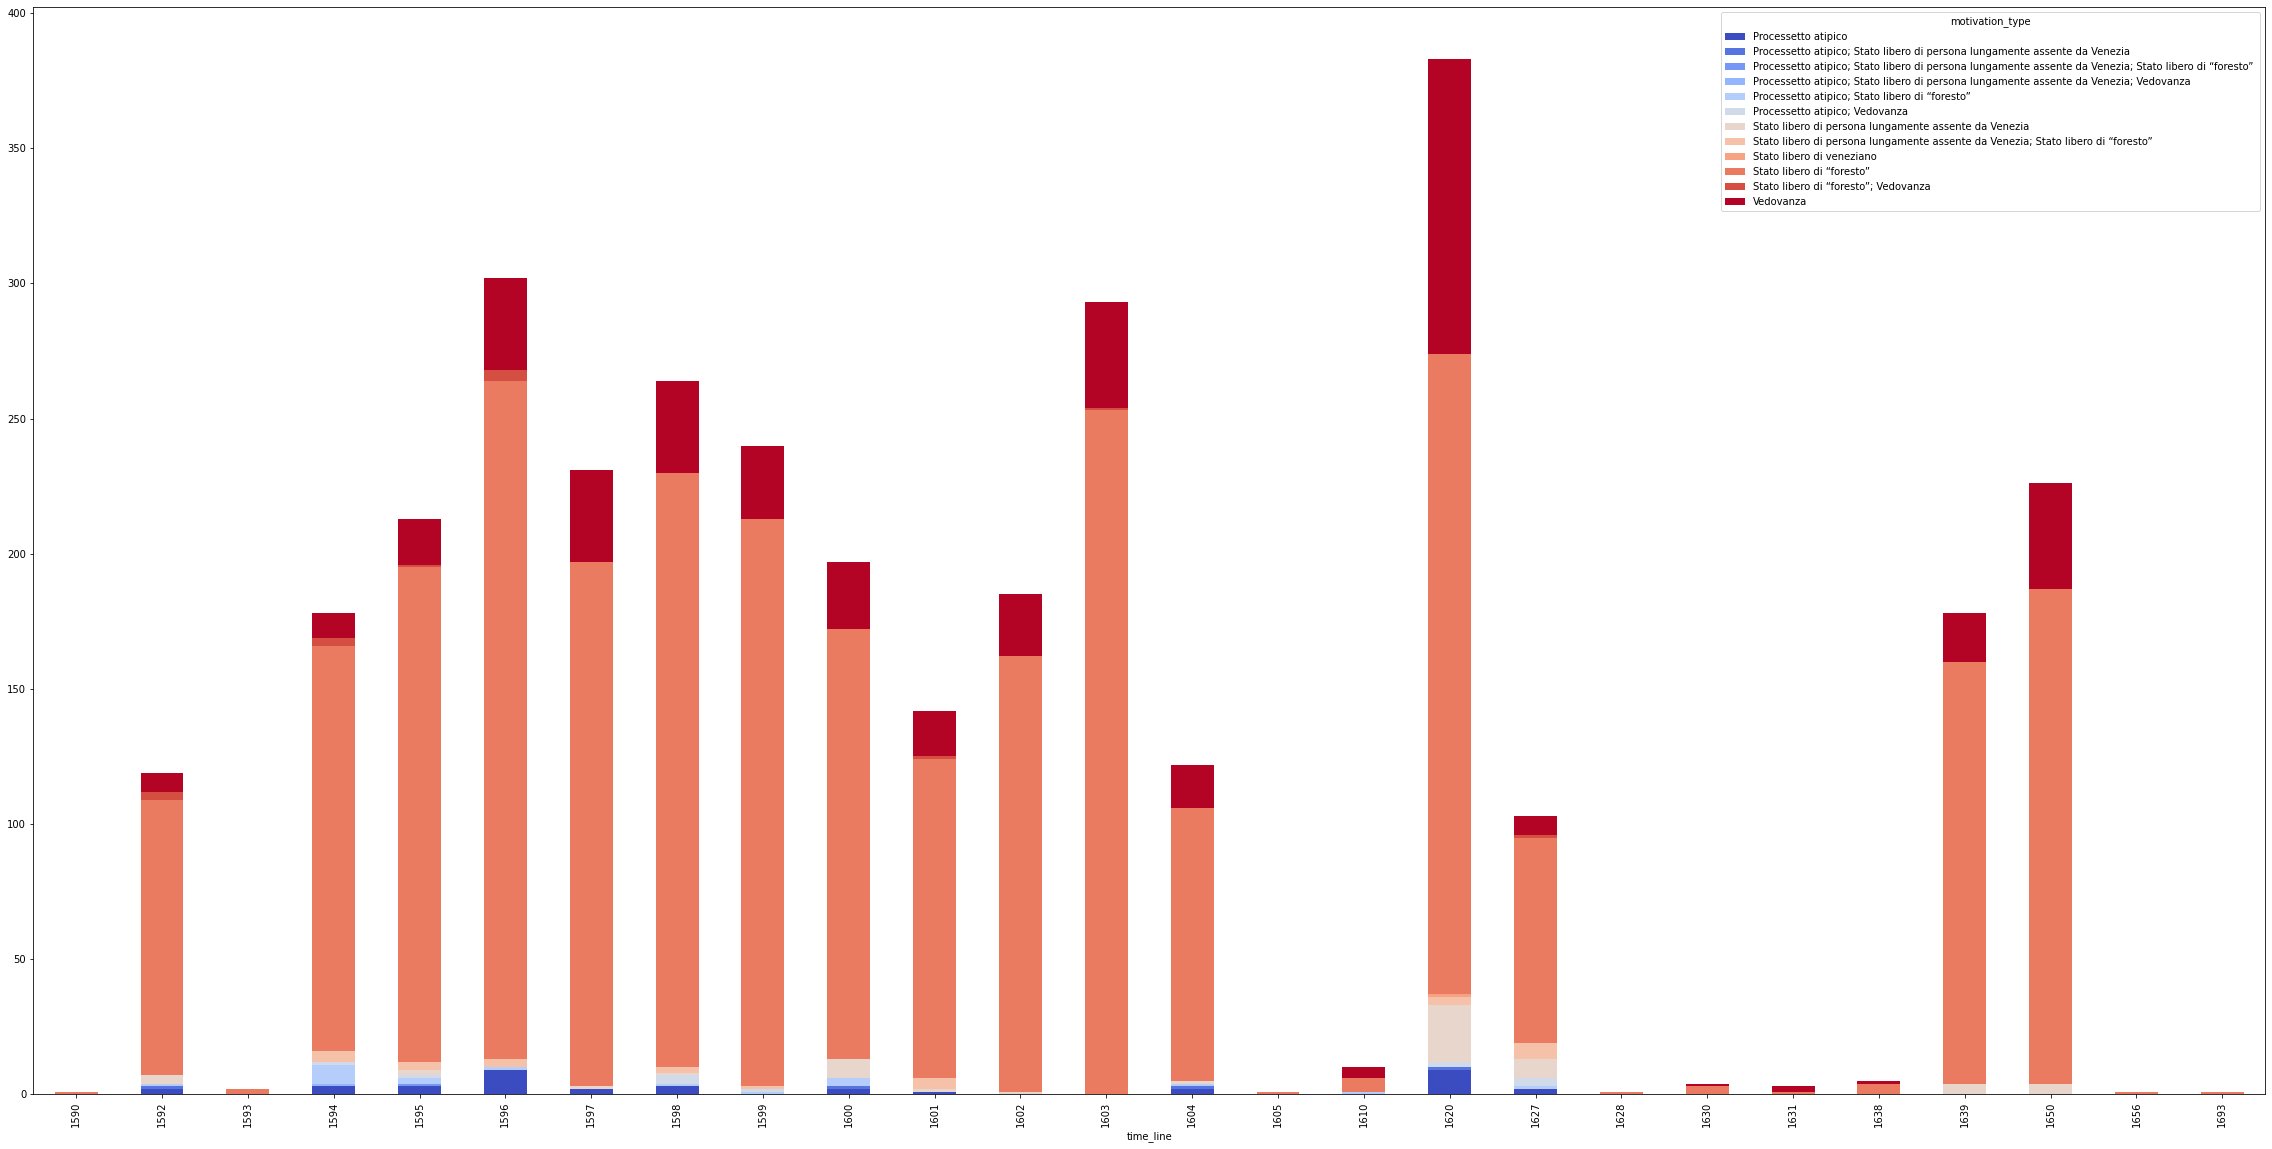

In [27]:
time_line.merge(df_proc, left_on='time_line', right_on='anno', how='left').pivot_table(values='pk_processetto', index='time_line', columns='motivation_type', aggfunc='count', fill_value=0).plot.bar(stacked="true", figsize=(40,20), colormap='coolwarm')

--------------------------------

# II. Profilo dei richiedenti e dei testimoni

**Obiettivo**: Analizzare e visualizzare l'età dei richiedenti e dei testimoni, incrociando il dato con: genere, origine, occupazione (per raggruppamento principale), motivation type

## Richiedenti:

Età dei richiedenti al momento del processetto

In [18]:
file = 'geovistory_query_exports/nb_richiedenti_20220510.json'

with open(file, encoding='utf-8') as json_file:
    data_ric = json.load(json_file)

dmr = DotMap(data_ric)
dmr_r = dmr.rows 

# Richiedenti list = rl

rl = [['pk_processetto',  'pk_person', 'person', 'qualità', 'genere', 'origini', 'anno_nascita', 'professioni' ]]


for r in dmr_r:
    for el in r.col_0.entities:
        element = []
        element += [el.pk_entity]

        # pk_person, person, qualità, genere
        element += [r.col_1.entity.pk_entity, clean_up_str(r.col_1.entity.entity_label), 'richiedente', (
            r.col_2.entities[0].entity_label if len(r.col_2.entities)>0 else np.nan)]
        
        # origini
        element += [clean_up_str('; '.join(e.entity_label for e in r.col_3.entities)) if len(r.col_3.entities)>=1 else np.nan]

        # Anno di nascita 
        element += [date(r.col_4)]
        
        # professioni
        element += ['; '.join(e.entity_label for e in r.col_5.entities) if len(r.col_5.entities)>=1 else np.nan]
        
        rl.append(element)


df_ric = pd.DataFrame(rl[1:], columns=rl[0])
df_ric = df_ric.merge(df_proc[['pk_processetto', 'motivation_type', 'mt_priorita',  'anno']], on='pk_processetto', how='left')
df_ric['età'] = df_ric['anno'] - df_ric['anno_nascita']
df_ric = df_ric[['pk_processetto', 'pk_person', 'person', 'qualità', 'età', 'anno_nascita', 'genere', 'origini', 'professioni', 'motivation_type', 'mt_priorita']]; df_ric.head()



,pk_processetto,pk_person,person,qualità,età,anno_nascita,genere,origini,professioni,motivation_type,mt_priorita
0,1006519,1006422,Giovanni di Michele (da Cessalto),richiedente,21.0,1576.0,Maschile,Cessalto,NaN,Stato libero di “foresto”,stato libero
1,1006883,1006794,"Pietro di Gennaro Costinovi (da Bergamo, tesse...",richiedente,21.0,1576.0,Maschile,Bergamo,cogo; tesser da panni,Stato libero di “foresto”,stato libero
2,1007147,1006856,Orsola di Angelo Collotis (da Visinale),richiedente,26.0,1572.0,Femminile,Visinale,masser,Stato libero di “foresto”,stato libero
3,1007355,1007216,Ortensia di Leonardo Verona (da Venzone),richiedente,25.0,1573.0,Femminile,Venzone,masser,Stato libero di “foresto”,stato libero
4,1007563,1007388,"Vincenzo di Battista Betocchi (da Gandino, cas...",richiedente,26.0,1572.0,Maschile,Gandino,casariol,Stato libero di “foresto”,stato libero


In [24]:
eta_tipo = df_ric[(df_ric['età']>7)&(df_ric['età']<70)][['età', 'mt_priorita']].pivot_table(index='età', columns='mt_priorita', aggfunc=len).fillna(0)

<AxesSubplot:xlabel='età'>

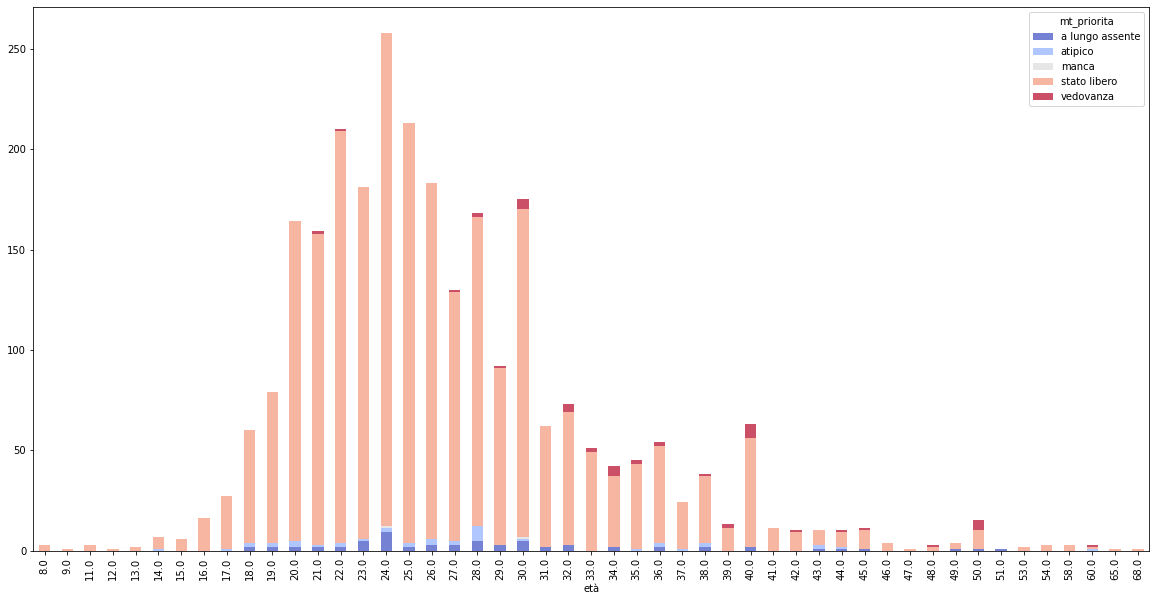

In [30]:
eta_tipo.plot.bar(stacked = True, figsize=(20,10), colormap='coolwarm', alpha=0.7)

In [106]:
temp = range(0,150,5)
l_list = []
for e in temp:
        l_list.append((e+1,e+5))

lustro = []
for e in df_ric['età'].fillna(0):
    if e in range(1,71):
        for rg in l_list:
            if e in range(rg[0], rg[1]+1):
                lustro.append('-'.join(str(r) for r in rg))
    else:
        lustro.append(np.nan)
    
df_ric['lustro'] = lustro


<AxesSubplot:xlabel='lustro'>

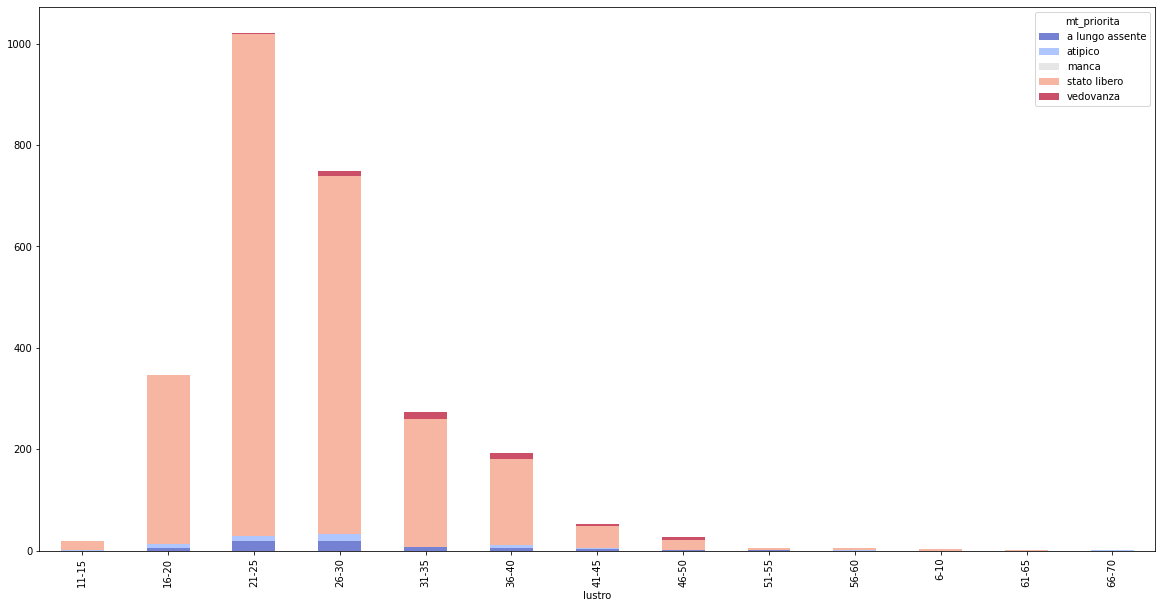

In [110]:
df_ric[(df_ric['lustro'].notnull())][['lustro', 'mt_priorita']].pivot_table(index='lustro', columns='mt_priorita', aggfunc=len).fillna(0).plot.bar(stacked = True, figsize=(20,10), colormap='coolwarm', alpha=0.7)

<AxesSubplot:xlabel='lustro'>

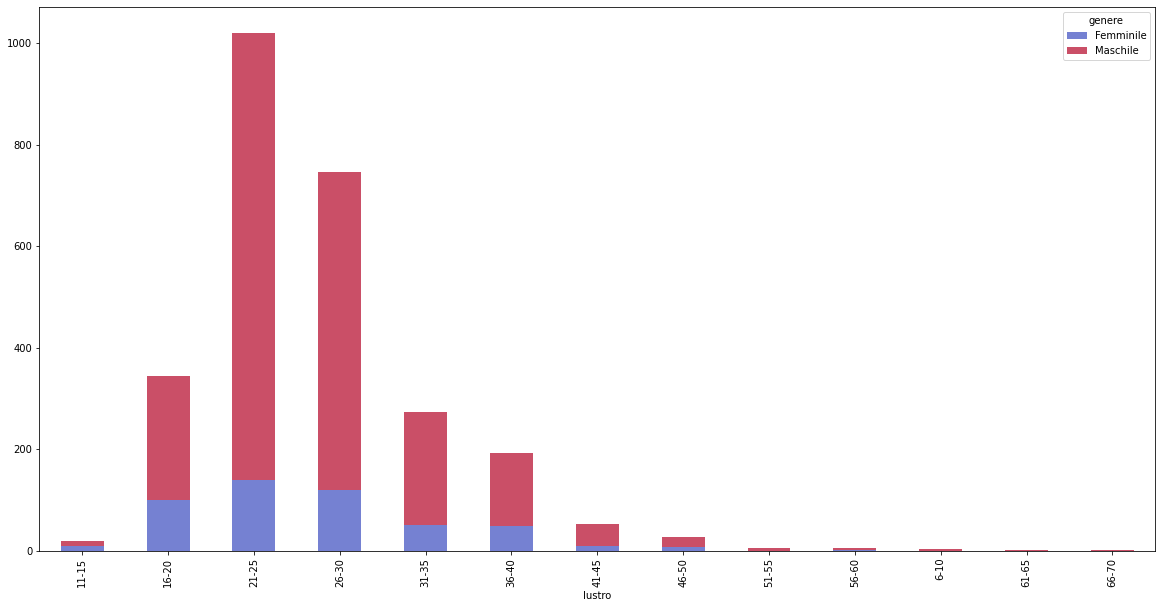

In [111]:
 df_ric[(df_ric['lustro'].notnull())][['lustro', 'genere']].pivot_table(index='lustro', columns='genere', aggfunc=len).fillna(0).plot.bar(stacked = True, figsize=(20,10), colormap='coolwarm', alpha=0.7)

In [138]:
a = df_ric[(df_ric['età'].notnull())][['età', 'genere']].pivot_table(index='età', columns='genere', aggfunc=len).fillna(0).reset_index()

<AxesSubplot:ylabel='Frequency'>

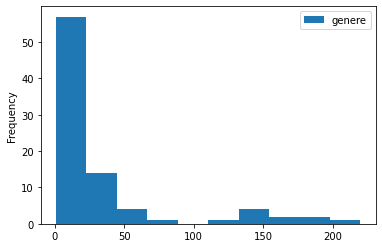

In [164]:
df_ric.groupby(['genere', 'età']).agg({'genere':'count'}).plot.hist()

genere,età,Femminile,Maschile
51,117.0,0.0,1.0
